## Section one: importing necessary packages and functions

In [28]:
import pandas as pd    
import geopandas as gpd
from geopandas.tools import geocode
#import geoplot
import numpy as np
import scipy.stats as stats
import scipy
import shapely
from shapely import speedups
speedups.enabled
import seaborn as sns
import matplotlib 
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 20})

import get_geodata
from get_geodata import get_gdf
from get_geodata import get_census_bounds
from get_geodata import get_zipcode_bounds

In [29]:
census_bounds = get_census_bounds()

In [30]:
census_bounds.head()

,NAME10,SHAPE_Area,geometry
0,25.0,1.059462e+07,"POLYGON ((-122.29602 47.69023, -122.29608 47.6..."
1,26.0,1.339838e+07,"POLYGON ((-122.30817 47.69031, -122.30947 47.6..."
2,56.0,3.212601e+07,"POLYGON ((-122.39300 47.63956, -122.39421 47.6..."
3,68.0,7.729233e+06,"POLYGON ((-122.35070 47.63994, -122.35130 47.6..."
4,60.0,1.413816e+07,"POLYGON ((-122.34279 47.64320, -122.34280 47.6..."


In [32]:
zip_bounds = get_zipcode_bounds()

In [33]:
zip_bounds.head()

,geometry,NAME10,SHAPE_Area_left
ZIPCODE,,,
98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07
98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",74.02,4.322189e+07
98103,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",45.00,1.440083e+08
98104,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",84.00,2.108730e+07
98105,"MULTIPOLYGON (((-122.32859 47.66646, -122.3285...",41.00,9.703543e+07


In [34]:
gdf_15 = get_gdf(15)
gdf_15.head()

,YEAR,AAWDT,GEOBASID,STNAME,SHAPE_Length,geometry
0,2015,24000.0,2028.0,W SEA BR EB 4 AV OFF RP,1458.971527,"LINESTRING (-122.33092 47.57152, -122.33054 47..."
1,2015,38000.0,2029.0,MYERS WAY S,335.499087,"LINESTRING (-122.33484 47.52232, -122.33482 47..."
2,2015,13000.0,2030.0,S CLOVERDALE ST,987.546181,"LINESTRING (-122.32820 47.52648, -122.32961 47..."
3,2015,11000.0,2031.0,S CLOVERDALE ST,1305.323633,"LINESTRING (-122.32292 47.52647, -122.32377 47..."
4,2015,12200.0,2032.0,M L KING JR WAY S,609.897683,"LINESTRING (-122.28085 47.53540, -122.28087 47..."


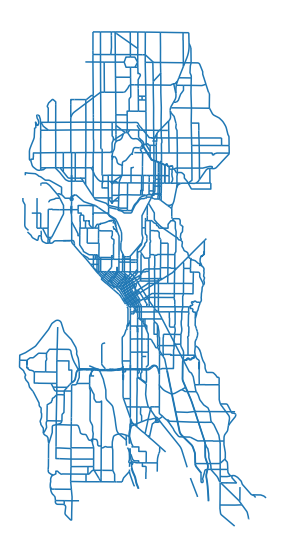

In [15]:
gdf_15.plot(figsize = (15,10))
plt.axis('off')
plt.show()

## Section two: segmenting street data by census tract

### 2a: adding census tract info to street info

This first example is the simplest way to select a specific tract from the census bounds. Note at this point we are only using the census data and not the street data. For the example I've selected the tract where the University is located.

In [10]:
census_selection = census_bounds.loc[census_bounds['NAME10'] == '53.02']

In [11]:
census_selection

,OBJECTID,TRACT,TRACTCE10,GEOID10,NAME10,NAMELSAD10,ACRES_TOTAL,WATER,SHAPE_Length,SHAPE_Area,geometry
84,128,5302,005302,53033005302,53.02,Census Tract 53.02,577.317916,0,33889.310995,2.514797e+07,"POLYGON ((-122.30653 47.66126, -122.30725 47.6..."


The following is just a plot of all of the census tracts in gray with a plot of the selected census tract overlaid in red.

<AxesSubplot:>

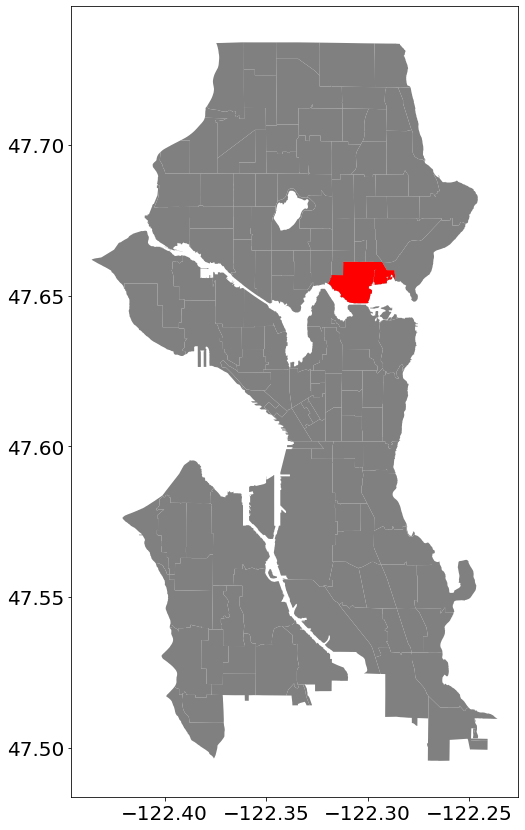

In [12]:
fig, ax = plt.subplots(figsize = (8, 16))

census_bounds.plot(ax=ax, facecolor='gray')
census_selection.plot(ax=ax, facecolor='red')

Now we can start to segment the street data by census tract. This first method is best for just individual selections and is probably not the most efficient. You can generate a boolean mask using the census selection and then use it to filter the street data.

In [13]:
Udist_mask = gdf_15.within(census_selection.at[84, 'geometry'])
print(Udist_mask)

0       False
1       False
2       False
3       False
4       False
        ...  
1855    False
1856    False
1857    False
1858    False
1859    False
Length: 1860, dtype: bool


In [14]:
Udist_data = gdf_15.loc[Udist_mask]
Udist_data.describe()

,AAWDT,GEOBASID,SHAPE_Length
count,30.000000,30.000000,30.000000
mean,14215.277520,1415.233333,536.509590
std,11912.652166,152.400037,553.674731
min,2200.000000,1307.000000,82.251670
25%,4225.000000,1363.250000,247.449472
50%,12145.700974,1388.500000,291.558616
75%,21000.000000,1402.750000,692.835239
max,43594.803000,1961.000000,2966.829559


<AxesSubplot:>

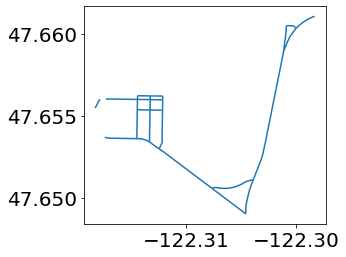

In [15]:
Udist_data.plot()

The better way to do this in my opinion is to join the census data with the street data - then all street data will have its associated census tractk, and you can select specific census tracts by indexing the dataframe. Here is the code to do that:

In [16]:
tracts_by_street = gpd.sjoin(gdf_15, census_bounds, op='within')
tracts_by_street.head()

,YEAR,AAWDT,GEOBASID,STNAME,SHAPE_Length_left,geometry,index_right,OBJECTID,TRACT,TRACTCE10,GEOID10,NAME10,NAMELSAD10,ACRES_TOTAL,WATER,SHAPE_Length_right,SHAPE_Area
0,2015,24000.000,2028.0,W SEA BR EB 4 AV OFF RP,1458.971527,"LINESTRING (-122.33092 47.57152, -122.33054 47...",97,141,9300,009300,53033009300,93,Census Tract 93,2341.806557,0,53536.277831,1.020091e+08
9,2015,10000.000,2040.0,S SPOKANE CR ST,74.907110,"LINESTRING (-122.32599 47.57156, -122.32569 47...",97,141,9300,009300,53033009300,93,Census Tract 93,2341.806557,0,53536.277831,1.020091e+08
28,2015,2000.000,2002.0,4TH AV NB ON RP,362.035102,"LINESTRING (-122.32905 47.58934, -122.32926 47...",97,141,9300,009300,53033009300,93,Census Tract 93,2341.806557,0,53536.277831,1.020091e+08
29,2015,7000.000,2003.0,AIRPORT WAY S,480.942822,"LINESTRING (-122.32248 47.59018, -122.32248 47...",97,141,9300,009300,53033009300,93,Census Tract 93,2341.806557,0,53536.277831,1.020091e+08
32,2015,10059.796,2006.0,EAST MARGINAL WAY S,1422.024871,"LINESTRING (-122.33968 47.57170, -122.33969 47...",97,141,9300,009300,53033009300,93,Census Tract 93,2341.806557,0,53536.277831,1.020091e+08


In [17]:
university_2015 = tracts_by_street.loc[tracts_by_street['NAME10'] == '53.02']

In [18]:
university_2015

,YEAR,AAWDT,GEOBASID,STNAME,SHAPE_Length_left,geometry,index_right,OBJECTID,TRACT,TRACTCE10,GEOID10,NAME10,NAMELSAD10,ACRES_TOTAL,WATER,SHAPE_Length_right,SHAPE_Area
64,2015,21672.120640,1960.0,NE PACIFIC ST,426.892327,"LINESTRING (-122.30597 47.64970, -122.30515 47...",84,128,5302,005302,53033005302,53.02,Census Tract 53.02,577.317916,0,33889.310995,2.514797e+07
65,2015,24000.000000,1961.0,EASTLAKE AVE NE,225.306037,"LINESTRING (-122.31784 47.65602, -122.31797 47...",84,128,5302,005302,53033005302,53.02,Census Tract 53.02,577.317916,0,33889.310995,2.514797e+07
561,2015,43594.803000,1412.0,MONTLAKE BLVD NE,2966.829559,"LINESTRING (-122.30114 47.65898, -122.30207 47...",84,128,5302,005302,53033005302,53.02,Census Tract 53.02,577.317916,0,33889.310995,2.514797e+07
572,2015,31500.000000,1423.0,MONTLAKE BLVD NE,575.275702,"LINESTRING (-122.30001 47.66035, -122.30004 47...",84,128,5302,005302,53033005302,53.02,Census Tract 53.02,577.317916,0,33889.310995,2.514797e+07
573,2015,19500.000000,1424.0,25TH AVE NE,560.713939,"LINESTRING (-122.30114 47.65898, -122.30106 47...",84,128,5302,005302,53033005302,53.02,Census Tract 53.02,577.317916,0,33889.310995,2.514797e+07
574,2015,5500.000000,1425.0,NE 44TH ST,241.814169,"LINESTRING (-122.30091 47.66051, -122.30028 47...",84,128,5302,005302,53033005302,53.02,Census Tract 53.02,577.317916,0,33889.310995,2.514797e+07
575,2015,36000.000000,1428.0,MONTLAKE BLVD NE,495.856467,"LINESTRING (-122.29834 47.66109, -122.29847 47...",84,128,5302,005302,53033005302,53.02,Census Tract 53.02,577.317916,0,33889.310995,2.514797e+07
598,2015,2500.000000,1403.0,NE CAMPUS PKWY,285.005152,"LINESTRING (-122.31326 47.65622, -122.31442 47...",84,128,5302,005302,53033005302,53.02,Census Tract 53.02,577.317916,0,33889.310995,2.514797e+07
612,2015,14000.000000,1363.0,15TH AVE NE,878.010612,"LINESTRING (-122.31246 47.65298, -122.31234 47...",84,128,5302,005302,53033005302,53.02,Census Tract 53.02,577.317916,0,33889.310995,2.514797e+07
613,2015,4000.000000,1364.0,UNIVERSITY WAY NE,712.956092,"LINESTRING (-122.31333 47.65340, -122.31333 47...",84,128,5302,005302,53033005302,53.02,Census Tract 53.02,577.317916,0,33889.310995,2.514797e+07


<AxesSubplot:>

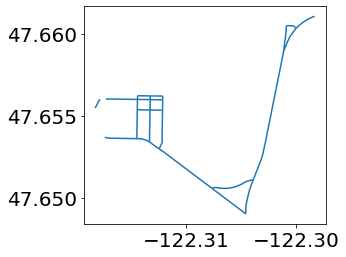

In [19]:
university_2015.plot()

In [20]:
tracts_by_street_diss = tracts_by_street.dissolve(by='NAME10')

### 2b: Aggregating street info by census tract

Finally, we can aggregate the street info by census tract for better visualization.

In [37]:
city_by_zip = gpd.sjoin(zip_bounds, gdf_15, op='intersects')

In [18]:
gdf_15.describe()

,AAWDT,GEOBASID,SHAPE_Length
count,1860.000000,1859.000000,1860.000000
mean,12210.741481,1031.557827,1337.628768
std,9907.991638,585.419003,1382.193543
min,600.000000,3.000000,48.541264
25%,5500.000000,540.500000,365.229349
50%,9770.436000,1021.000000,834.996772
75%,16000.000000,1537.500000,1792.337167
max,108178.569998,4493.000000,13076.444950


In [38]:
city_by_zip.head()

,geometry,NAME10,SHAPE_Area_left,index_right,YEAR,AAWDT,GEOBASID,STNAME,SHAPE_Length
ZIPCODE,,,,,,,,,
98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,1163,2015,10639.335836,800.0,ALASKAN WAY,1245.144941
98121,"POLYGON ((-122.36110 47.61854, -122.36095 47.6...",81.00,1.225219e+07,1163,2015,10639.335836,800.0,ALASKAN WAY,1245.144941
98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,1186,2015,2500.000000,823.0,VIRGINIA ST,372.729354
98121,"POLYGON ((-122.36110 47.61854, -122.36095 47.6...",81.00,1.225219e+07,1186,2015,2500.000000,823.0,VIRGINIA ST,372.729354
98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,1197,2015,11000.000000,705.0,ALASKAN WAY,613.438180


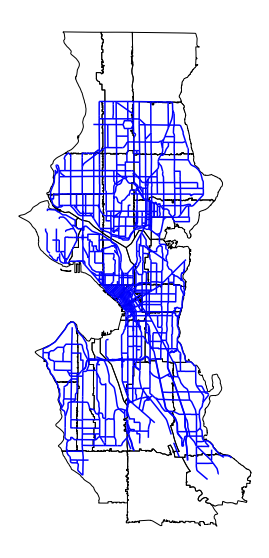

In [42]:
fig, ax = plt.subplots(figsize=(15,10))
zip_bounds.plot(ax=ax, facecolor='none', edgecolor='k')
gdf_15.plot(ax=ax, color='blue')
plt.axis('off')
plt.show()

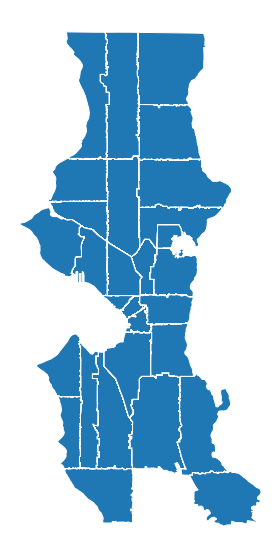

In [39]:
city_by_zip.plot(edgecolor='white', figsize=(15,10))
plt.axis('off')
plt.show()

In [38]:
sarahs_house = city_by_tract.loc[city_by_tract['NAME10'] == '51']

In [39]:
sarahs_house.head()

,OBJECTID,TRACT,TRACTCE10,GEOID10,NAME10,NAMELSAD10,ACRES_TOTAL,WATER,SHAPE_Length_left,SHAPE_Area,geometry,index_right,YEAR,AAWDT,GEOBASID,STNAME,SHAPE_Length_right
43,84,5100,005100,53033005100,51,Census Tract 51,217.863647,0,13462.590731,9.490140e+06,"POLYGON ((-122.32827 47.66500, -122.32906 47.6...",620,2015,11227.385174,1374.0,NE PACIFIC ST,4571.349948
43,84,5100,005100,53033005100,51,Census Tract 51,217.863647,0,13462.590731,9.490140e+06,"POLYGON ((-122.32827 47.66500, -122.32906 47.6...",628,2015,12802.605000,1383.0,N 40TH ST,2325.627711
43,84,5100,005100,53033005100,51,Census Tract 51,217.863647,0,13462.590731,9.490140e+06,"POLYGON ((-122.32827 47.66500, -122.32906 47.6...",510,2015,22547.056000,1458.0,NE 45TH ST,1857.804215
43,84,5100,005100,53033005100,51,Census Tract 51,217.863647,0,13462.590731,9.490140e+06,"POLYGON ((-122.32827 47.66500, -122.32906 47.6...",486,2015,24607.640000,1521.0,NE 50TH ST,1871.015826
43,84,5100,005100,53033005100,51,Census Tract 51,217.863647,0,13462.590731,9.490140e+06,"POLYGON ((-122.32827 47.66500, -122.32906 47.6...",627,2015,4044.291412,1382.0,WALLINGFORD AVE N,2353.939940


<AxesSubplot:>

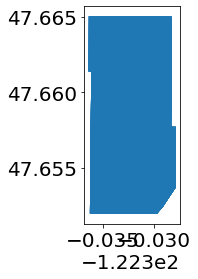

In [40]:
sarahs_house.plot()

In [41]:
test = sarahs_house['AAWDT'].sum()

In [43]:
traffic_zones = city_by_zip.dissolve(by='ZIPCODE', aggfunc = sum)

In [43]:
traffic_zones.reset_index(inplace = True)

In [15]:
traffic_zones.describe()

,OBJECTID,TRACT,ACRES_TOTAL,WATER,SHAPE_Length_left,SHAPE_Area,index_right,AAWDT,GEOBASID,SHAPE_Length_right
count,134.000000,1.340000e+02,134.000000,134.0,1.340000e+02,1.340000e+02,134.000000,1.340000e+02,134.000000,134.000000
mean,2279.089552,1.423019e+05,9905.774565,0.0,4.692653e+05,4.314955e+08,18939.873134,2.601562e+05,22229.917910,32911.771931
std,2895.118467,1.769169e+05,26330.069445,0.0,7.157692e+05,1.146938e+09,25320.967471,2.645114e+05,21387.008914,19007.845936
min,10.000000,9.000000e+02,31.812502,0.0,1.194697e+04,1.385753e+06,779.000000,2.944862e+04,251.000000,7778.973253
25%,576.000000,3.350450e+04,2770.313241,0.0,1.647922e+05,1.206748e+08,3625.750000,9.859430e+04,9230.250000,21964.449617
50%,1385.000000,9.681000e+04,4706.502710,0.0,2.633827e+05,2.050153e+08,12239.000000,1.888396e+05,16668.000000,28738.942680
75%,2848.000000,1.692000e+05,9723.364074,0.0,5.379787e+05,4.235497e+08,22716.250000,2.994776e+05,28345.000000,40537.458903
max,17343.000000,1.143900e+06,288042.206558,0.0,6.584962e+06,1.254712e+10,174199.000000,1.890148e+06,103356.000000,163153.529192


In [45]:
traffic_zones = traffic_zones[['NAME10','geometry', 'AAWDT' ]]

In [46]:
traffic_zones.head()

,NAME10,geometry,AAWDT
ZIPCODE,,,
98101,13323.60,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",1.877668e+06
98102,2738.74,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",4.782904e+05
98103,5670.00,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",1.880369e+06
98104,13944.00,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",1.847450e+06
98105,6560.00,"MULTIPOLYGON (((-122.32859 47.66646, -122.3285...",1.762661e+06


In [47]:
traffic_zones['NAME10'].value_counts()

10       1
76       1
118      1
8        1
87       1
        ..
103      1
43.02    1
71       1
88       1
92       1
Name: NAME10, Length: 134, dtype: int64

In [48]:
test_frame = traffic_zones[traffic_zones['NAME10'] == '51']

In [49]:
test_frame['AAWDT'] == test

77    True
Name: AAWDT, dtype: bool

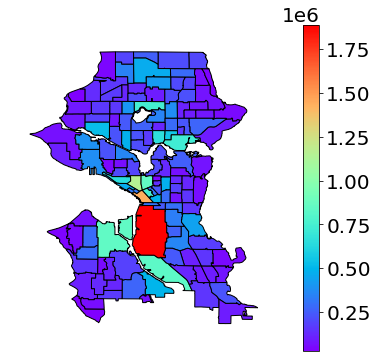

In [50]:
ave_traffic = traffic_zones['AAWDT']
#scheme = mapclassify.NaturalBreaks(ave_traffic, k=10)
geoplot.choropleth(traffic_zones, hue=ave_traffic, cmap='rainbow', legend = True)
plt.show()